In [1]:
import numpy as np
import random
from digipath.plotter import plotter
import monai
import monai.transforms as transforms
import torch
import torchvision
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import math
from monai.inferers import sliding_window_inference
import sklearn

/home/gpievanitrapletti/.conda/envs/gym/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load data
train_data = np.load('data/tiles/train_data.npz')
val_data = np.load('data/tiles/val_data.npz')
test_data = np.load('data/tiles/test_data.npz')


# train_tiles = train_tiles.transpose(0, 3, 1, 2)
# train_gts = train_gts[:, np.newaxis, :, :]

# # Test
# test_tiles = np.load('data/tiles/test_tiles.npy')
# test_tiles = test_tiles.transpose(0, 3, 1, 2)
# test_gts = np.load('data/tiles/test_gts.npy')
# test_gts = test_gts[:, np.newaxis, :, :]

# print(train_tiles.shape, train_gts.shape)
# print(test_tiles.shape, test_gts.shape)

In [3]:
# Change channels position, as required by Monai transforms
train_tiles = np.concatenate([x.transpose(2, 0, 1)[np.newaxis, ...] for x in train_data['images']])
val_tiles = np.concatenate([x.transpose(2, 0, 1)[np.newaxis, ...] for x in val_data['images']])
test_tiles = np.concatenate([x.transpose(2, 0, 1)[np.newaxis, ...] for x in test_data['images']])

train_gts = np.concatenate([x[np.newaxis, np.newaxis, ...] for x in train_data['masks']])
val_gts = np.concatenate([x[np.newaxis, np.newaxis, ...] for x in val_data['masks']])
test_gts = np.concatenate([x[np.newaxis, np.newaxis, ...] for x in test_data['masks']])

print(len(train_tiles), len(val_tiles), len(test_tiles))
print(len(train_gts), len(val_gts), len(test_gts))

5173 1489 742
5173 1489 742


In [35]:
print((train_tiles.shape), (val_tiles.shape), (test_tiles.shape))
print((train_gts.shape), (val_gts.shape), (test_gts.shape))

(5173, 3, 64, 64) (1489, 3, 64, 64) (742, 3, 64, 64)
(5173, 1, 64, 64) (1489, 1, 64, 64) (742, 1, 64, 64)


# <ins> NORMALIZATION

## DATASET MEAN AND STD

In [36]:
mean = np.mean(train_tiles, axis=0)
std = np.std(train_tiles, axis=0)

mean.shape, std.shape

((3, 64, 64), (3, 64, 64))

In [37]:
train_tiles_norm = (train_tiles - mean) / std

In [38]:
train_tiles_norm.mean(), train_tiles_norm.std()

(4.771512351629382e-17, 0.9999999999999992)

2023-03-02 21:37:55,823 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


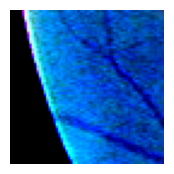

In [39]:
i = random.randint(0, 1001)
tile = train_tiles_norm[i].transpose(1, 2, 0)
plotter(tile, 2)

In [62]:
# norm_mean = np.zeros(shape=(1, 3))

# for image in train_tiles:
#     image = image.transpose(1, 2, 0)
#     # image /= 255.0
#     image_mean = np.mean(image, axis=(0, 1))
#     norm_mean = np.add(norm_mean, image_mean)

# norm_mean = (norm_mean/len(train_tiles)).astype(np.uint8)
# norm_mean

In [63]:
# norm_variance = np.zeros(3)

# for image in train_tiles:
#     image = image.transpose(1, 2, 0)
#     for channel_idx in range(image.shape[-1]):
#         channel = image[:, :, channel_idx]
#         channel_variance = ((channel - norm_mean[0][channel_idx])**2).sum() / (channel.shape[0]*channel.shape[1])
#         norm_variance[channel_idx] += channel_variance

# norm_variance = norm_variance/len(train_tiles)
# norm_std = (np.sqrt(norm_variance)).astype(np.uint8)
# norm_std

In [40]:
# Transforms with normalization of tiles (and not masks).
mytransform = monai.transforms.Compose([
    transforms.RandRotated(keys=['image', 'mask'], range_x=[0, 180], prob=0.9),
    transforms.RandAxisFlipD(keys=['image', 'mask'], prob=0.9),
    # transforms.Rand2DElasticD(keys=['image', 'mask'], spacing=(5), magnitude_range=(2, 5), prob=0.9),
    transforms.NormalizeIntensityD(keys=['image'], subtrahend=mean, divisor=std),
    transforms.ToTensorD(keys=['image', 'mask'])
])

In [59]:
# Dataset as dict, as required by the transforms 
# (to apply transforms in the same way for both the image and the mask)
train_datadict = [{'image': train_tiles[i], 'mask': train_gts[i]} for i in range(len(train_tiles))]

In [60]:
# Dataset
train_dataset = monai.data.Dataset(data=train_datadict, transform=mytransform)

In [61]:
# Get data transformed (needed to get tile and masks transformed in the same way)
# basically this is just a simulation of how the dataset would work
train_data = [train_dataset[i] for i in tqdm(range(len(train_dataset)))]

# # DO NOT DO THIS!
# tile_transformed = dataset[0]['image']
# mask_transformed = dataset[0]['mask']
# # In this way dataset[0] is created two separate times, thus resulting in 
# # different transforms (ex. tile rotate to the righr while mask rotate to the left)

100%|██████████| 742/742 [00:07<00:00, 104.20it/s]


In [62]:
i = 0

2023-03-02 21:48:00,293 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
(64, 64, 1)


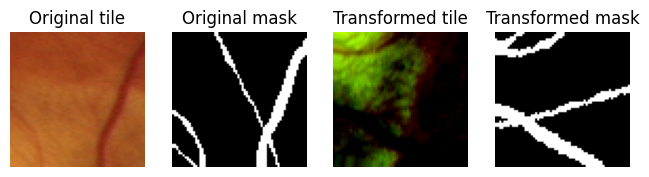

In [64]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(8, 3))

axes[0].imshow(train_tiles[i].transpose(1, 2, 0))
axes[0].set_title('Original tile')
axes[0].axis('off')

axes[1].imshow(train_gts[i].transpose(1, 2, 0), cmap='gray')
axes[1].set_title('Original mask')
axes[1].axis('off')

axes[2].imshow(train_data[i]['image'].numpy().transpose(1, 2, 0))
axes[2].set_title('Transformed tile')
axes[2].axis('off')

mask = train_data[i]['mask'].numpy().transpose(1, 2, 0).astype(np.uint8)
mask = np.where(mask != 0, 255, 0)
print(mask.shape)                                                             ### !
axes[3].imshow(mask, cmap='gray')
axes[3].set_title('Transformed mask')
axes[3].axis('off')

plt.show()

i += 1

# <ins> TRANSFORMS

In [65]:
train_transforms = monai.transforms.Compose([
    transforms.RandRotated(keys=['image', 'mask'], range_x=[0, 180], prob=0.5),
    transforms.RandAxisFlipD(keys=['image', 'mask'], prob=0.5),
    transforms.NormalizeIntensityD(keys=['image'], subtrahend=mean, divisor=std),
    transforms.ToTensorD(keys=['image', 'mask'])
])

In [66]:
test_transforms = monai.transforms.Compose([
    transforms.NormalizeIntensityD(keys=['image'], subtrahend=mean, divisor=std),
    transforms.ToTensorD(keys=['image', 'mask'])
])

# <ins> DATASETS, DATALOADERS

In [67]:
val_datadict = [{'image': val_tiles[i], 'mask': val_gts[i]} for i in range(len(val_tiles))]
test_datadict = [{'image': test_tiles[i], 'mask': test_gts[i]} for i in range(len(test_tiles))]

In [68]:
# Datasets
val_dataset = monai.data.Dataset(data=val_datadict, transform=test_transforms)
test_dataset = monai.data.Dataset(data=test_datadict, transform=test_transforms)

In [69]:
# Dataloaders
train_dataloader = monai.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, pin_memory=torch.cuda.is_available(), num_workers=8)
val_dataloader = monai.data.DataLoader(dataset=val_dataset, batch_size=1, shuffle=True, pin_memory=torch.cuda.is_available(), num_workers=8)
test_dataloader = monai.data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=False, pin_memory=torch.cuda.is_available(), num_workers=8)

# <ins> MODEL

In [70]:
dice_metric = monai.metrics.DiceMetric(include_background=True, reduction="mean")

In [71]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [72]:
loss_function = monai.losses.DiceLoss(sigmoid=True)

In [ ]:
model = monai.networks.nets.UNet(
    spatial_dims=2, # 2D
    in_channels=3,
    out_channels=1,
    channels=(16, 32, 64, 128),
    strides=(2, 2, 2),
    num_res_units=3
)

model = torch.nn.Sequential(
    model, 
    torch.nn.Sigmoid()
)

model.to(device)

optimizer = torch.optim.Adam(model.parameters(), 1e-4)

n_epochs = 200
val_interval = 10
epoch_train_losses = []
epoch_val_losses = []
epoch_val_metrics = []
best_metric = -1
best_metric_epoch = -1

for epoch in range(n_epochs):
    # print("-" * 10)
    # print(f"Epoch {epoch + 1}/{n_epochs}")
    model.train()
    train_step_losses = [] # list with the loss of each step
    train_step = 0
    n_steps = len(train_dataset) // train_dataloader.batch_size # number of steps in an epoch 
    
    for train_batch in train_dataloader:
        train_step += 1
        images, gts = train_batch["image"], train_batch["mask"]
        gts = torch.where(gts > 0, 1, 0).astype(torch.float32)
        images, gts = images.to(device), gts.to(device)
        optimizer.zero_grad()
        preds = model(images)
        step_loss = loss_function(preds, gts)
        step_loss.backward()
        optimizer.step()
        train_step_losses.append(step_loss.item())
    
    epoch_train_loss = np.mean(train_step_losses) # the loss of the epoch as the average of the losses of the steps
    epoch_train_losses.append(epoch_train_loss)
    # print(f"train_loss: {epoch_train_loss:.3f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            val_step_losses = []
            val_step_metrics = []
            epoch_val_metric = 0
            val_step = 0
            
            for val_batch in val_dataloader:
                val_step += 1
                images, gts = val_batch["image"], val_batch["mask"]
                gts = torch.where(gts > 0, 1, 0).astype(torch.float32)
                images, gts = images.to(device), gts.to(device)
                preds = model(images)
                step_loss = loss_function(preds, gts)
                val_step_losses.append(step_loss.item())
                metric = dice_metric(  # metric requires binary masks
                    torch.where(preds > 0.5, True, False).astype(torch.float32), 
                    gts
                ) 
                val_step_metrics.append(metric.cpu().numpy()[0][0])

            epoch_val_loss = np.mean(val_step_losses)
            epoch_val_losses.append(epoch_val_loss)
            epoch_val_metric = np.mean(val_step_metrics)
            epoch_val_metrics.append(epoch_val_metric)
            print(f"Epoch: {epoch + 1} - val_loss: {epoch_val_loss:.3f} - val_metric: {epoch_val_metric:.3f}")

            if epoch_val_metric > best_metric:
                best_metric = epoch_val_metric
                best_metric_epoch = epoch + 1
            
                
print(f"Best metric: {best_metric} at epoch {best_metric_epoch}")

In [75]:
# 400 epochs --> Best metric: 0.569 at epoch 400
# 1000 epochs --> Best metric: 0.684 at epoch 1000

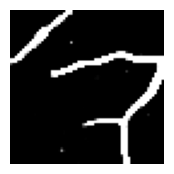

In [77]:
plotter(preds[0, 0, ...].cpu().numpy(), 2)

In [78]:
len(epoch_train_losses), len(epoch_val_losses), len(epoch_val_metrics)

(1000, 20, 20)

In [34]:
epoch_val_losses

[0.8065689185261726,
 0.8033659285306931,
 0.8012348890304566,
 0.7995563966035842,
 0.7981634241342545,
 0.7969153389334679,
 0.7957295912504196,
 0.7945616206526757,
 0.793596550822258,
 0.7926485839486123,
 0.791636560857296,
 0.7908973142504692,
 0.7900854656100273,
 0.789239187836647,
 0.7885064169764519,
 0.7878395622968674,
 0.7872101372480392,
 0.7866512969136238,
 0.7861019563674927,
 0.7854330316185951]

In [29]:
epoch_val_metrics

[0.4422819,
 0.470682,
 0.4907094,
 0.50956094,
 0.5304892,
 0.54556686,
 0.55217683,
 0.56886876,
 0.58077186,
 0.5924738,
 0.58929455,
 0.6055027,
 0.6077075,
 0.606933,
 0.6152946,
 0.6207117,
 0.6218823,
 0.63232404,
 0.62579376,
 0.63468397]

# <ins> TEST

In [79]:
model.eval()
outputs = []
metrics = []

with torch.no_grad():
    for batch in tqdm(test_dataloader):
        images, gts = batch["image"], batch["mask"]
        gts = torch.where(gts > 0, 1, 0).astype(torch.float32)
        images, gts = images.to(device), gts.to(device)
        preds = model(images)
        preds = torch.where(preds > 0.5, True, False).astype(torch.float32) # metric requires binary masks
        metric = dice_metric(preds, gts) 
        outputs.append(preds.cpu().numpy())
        metrics.append(metric.cpu().numpy())

outputs = np.concatenate(outputs)

print(type(outputs), outputs.dtype)
print(outputs.shape)
print(f'Test Dice: {np.mean(metrics):.3f}')

100%|██████████| 500/500 [00:08<00:00, 62.06it/s]

<class 'numpy.ndarray'> float32
(500, 1, 64, 64)
Test Dice: 0.690


In [80]:
outputs.min(), outputs.max(), np.unique(outputs)

(0.0, 1.0, array([0., 1.], dtype=float32))

2023-03-01 16:04:07,738 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


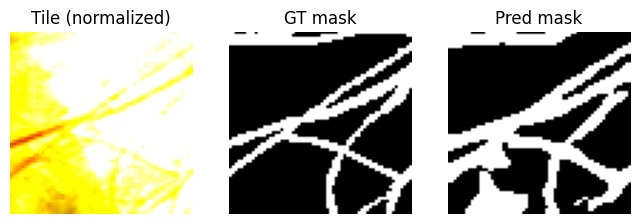

In [88]:
i = random.randint(0, len(test_dataset)-1)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8, 3))

axes[0].imshow(test_dataset[i]['image'].cpu().numpy().transpose(1, 2, 0))
axes[0].set_title('Tile (normalized)')
axes[0].axis('off')

axes[1].imshow(test_dataset[i]['mask'].cpu().numpy().transpose(1, 2, 0), cmap='gray')
axes[1].set_title('GT mask')
axes[1].axis('off')

axes[2].imshow(outputs[i][0, ...] > 0.5, cmap='gray')
axes[2].set_title('Pred mask')
axes[2].axis('off')

# mask = data[i]['mask'].numpy().transpose(1, 2, 0).astype(np.uint8)
# mask = np.where(mask != 0, 255, 0)
# print(mask.shape)                                                             ### !
# axes[3].imshow(mask, cmap='gray')
# axes[3].set_title('Transformed mask')
# axes[3].axis('off')

plt.show()

i += 1

In [89]:
gts = np.concatenate([(test_datadict[i]['mask'][np.newaxis, ...]>0.5).astype(np.float32) for i in range(len(test_datadict))])

print(type(gts))
print(gts.dtype)
print(gts.shape)

<class 'numpy.ndarray'>
float32
(500, 1, 64, 64)


In [90]:
# AUC for every prediction, then mean to get the overall AUC
aucs = []
for i in range(len(outputs)):
    pred = outputs[i][0, ...]
    gt = gts[i][0, ...]
    auc = sklearn.metrics.roc_auc_score(gt.flatten(), pred.flatten())
    aucs.append(auc)

np.round(np.mean(aucs), 3)

# Orobix retina repo: 0.9805
# 400 epochs: 0.906
# 1000 epochs: 0.935

0.935

In [91]:
def my_dice_metric(arr1, arr2):
    # assert list(np.unique(arr1)) == [0, 1]
    # assert list(np.unique(arr2)) == [0, 1]
    intersection = np.sum(arr1 * arr2)
    union = arr1.sum() + arr2.sum() + 1e-6
    return 2 * intersection / union

In [92]:
dices = []
for i in range(len(outputs)):
    pred = outputs[i][0, ...]
    gt = gts[i][0, ...]
    dice = my_dice_metric(pred, gt)
    dices.append(dice)

np.round(np.mean(dices), 3)

# 1000 epochs: 0.69

0.69

In [102]:
# # # VARIOUS

# trainer = monai.engines.SupervisedTrainer(
#     device=device,
#     max_epochs=50,
#     train_data_loader = train_dataloader,
#     network=model,
#     optimizer=optimizer,
#     loss_function=monai.losses.DiceLoss(sigmoid=True),
#     inferer=monai.inferers.SimpleInferer(),
# )

# trainer.run()
# # raise AssertionError(f"ground truth has different shape ({target.shape}) from input ({input.shape})")